In [ ]:
# célula 0 – instalação de dependências básicas
# aqui eu instalo/atualizo pip, setuptools, numpy, scipy e tqdm (para barra de progresso)
%pip install -q -U pip setuptools numpy scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.


In [ ]:
# célula 1 – instalação adaptativa do cupy + verificação da gpu
# aqui eu tento cupy-cuda12x; se o driver não suportar, troco para cupy-cuda11x.
# se mesmo assim a gpu não aparecer, marco `cupy_enabled = False` e pulo o benchmark gpu.
import subprocess, sys, importlib, gc

def _install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

cupy_enabled = False
for wheel in ("cupy-cuda12x", "cupy-cuda11x"):
    try:
        _install(wheel)
        import cupy as cp
        cp.zeros((1,))          # força alocação simples
        print(f"gpu ok com {wheel}")
        cupy_enabled = True
        break
    except Exception as e:
        print(f"falha com {wheel}: {e}")
        for m in list(sys.modules):
            if m.startswith("cupy"):
                del sys.modules[m]
        gc.collect()

if not cupy_enabled:
    print("cupy indisponível – benchmarks gpu serão pulados; lembre-se de ativar o runtime gpu em colab (runtime ▸ change runtime type ▸ gpu)")


gpu ok com cupy-cuda12x


In [ ]:
# célula 2 – parâmetros globais para testes rápidos (< 5 min)
# aqui eu defino tamanhos diferentes para python puro (menor) e numpy/cupy (maior).
sz_py   = 200      # tamanho da matriz no python puro
it_py   = 3        # repetições do bloco pesado no python puro

sz_fast = 500      # tamanho da matriz em numpy / cupy
it_fast = 30       # repetições para numpy / cupy


In [ ]:
# célula 3 – benchmark python puro com barra de progresso
import time, random
from tqdm.auto import tqdm

def multiplicacao_python(a, b):
    c = [[0.0]*sz_py for _ in range(sz_py)]
    for i in tqdm(range(sz_py), desc="linhas python"):
        for j in range(sz_py):
            s = 0.0
            for k in range(sz_py):
                s += a[i][k] * b[k][j]
            c[i][j] = s
    return c

# criando matrizes
a_std = [[random.random() for _ in range(sz_py)] for _ in range(sz_py)]
b_std = [[random.random() for _ in range(sz_py)] for _ in range(sz_py)]

print("\nbenchmark python puro – alvo < 5 min")
t0 = time.time()
for rep in range(it_py):
    print(f"  iteração {rep+1}/{it_py}")
    c_std = multiplicacao_python(a_std, b_std)
tempo_py = time.time() - t0
print(f"tempo total python puro: {tempo_py:.2f} s")



benchmark python puro – alvo < 5 min
  iteração 1/3


linhas python:   0%|          | 0/200 [00:00<?, ?it/s]

  iteração 2/3


linhas python:   0%|          | 0/200 [00:00<?, ?it/s]

  iteração 3/3


linhas python:   0%|          | 0/200 [00:00<?, ?it/s]

tempo total python puro: 2.46 s


In [ ]:
# célula 4 – benchmark numpy em cpu com barra de progresso
import numpy as np, time
a_cpu = np.random.rand(sz_fast, sz_fast)
b_cpu = np.random.rand(sz_fast, sz_fast)

print("\nbenchmark numpy (cpu)")
t0 = time.time()
for _ in tqdm(range(it_fast), desc="iterações numpy"):
    c_cpu = a_cpu @ b_cpu
    c_cpu = c_cpu @ a_cpu
    c_cpu = c_cpu @ b_cpu
tempo_np = time.time() - t0
print(f"tempo total numpy: {tempo_np:.2f} s")



benchmark numpy (cpu)


iterações numpy:   0%|          | 0/30 [00:00<?, ?it/s]

tempo total numpy: 1.34 s


In [ ]:
# célula 5 – benchmark cupy em gpu (executado apenas se cupy_enabled)
if cupy_enabled:
    import cupy as cp, time
    a_gpu = cp.asarray(a_cpu)
    b_gpu = cp.asarray(b_cpu)
    cp.cuda.Stream.null.synchronize()

    print("\nbenchmark cupy (gpu)")
    t0 = time.time()
    for _ in tqdm(range(it_fast), desc="iterações cupy"):
        c_gpu = a_gpu @ b_gpu
        c_gpu = c_gpu @ a_gpu
        c_gpu = c_gpu @ b_gpu
    cp.cuda.Stream.null.synchronize()
    tempo_cp = time.time() - t0
    print(f"tempo total cupy: {tempo_cp:.2f} s")
else:
    tempo_cp = None
    print("\nbenchmark gpu pulado – cupy desativado")



benchmark cupy (gpu)


iterações cupy:   0%|          | 0/30 [00:00<?, ?it/s]

tempo total cupy: 1.11 s



resumo (segundos):
  python :    2.46
  numpy  :    1.34
  cupy   :    1.11


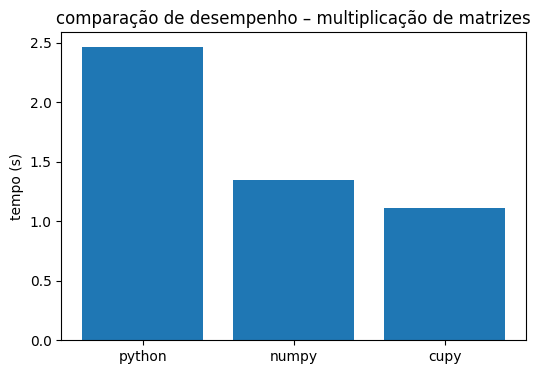

In [ ]:
# célula 6 – resumo em tabela e gráfico
import matplotlib.pyplot as plt

tempos = {
    "python": tempo_py,
    "numpy" : tempo_np,
}
if tempo_cp is not None:
    tempos["cupy"] = tempo_cp

# resumo em print
print("\nresumo (segundos):")
for k, v in tempos.items():
    print(f"  {k:<6} : {v:>7.2f}")

# gráfico de barras simples
plt.figure(figsize=(6,4))
plt.bar(list(tempos.keys()), list(tempos.values()))
plt.ylabel("tempo (s)")
plt.title("comparação de desempenho – multiplicação de matrizes")
plt.show()
